# Search for long range edges 

In this notebook, I will implement code to search for a long range edge(s) from a default `feems` by seeing if the likelihood increases with the addition of a certain edge. First, the search for the *best* edge will be done through a full grid search, wherein I iteratively add one long range edge after another over all pairs of nodes and check if this extra edge decreases the negative log likelihood. Second, I will implement a heuristic search by using a greedy approach to fit an edge between a pair of nodes that show maximum residuals with the default fit. 

To do this, I need to simulate a large empirical test case with many nodes. I will use the same corridor-barrier-corridor approach from previous simulations but with a much larger grid (40x80 is too large, for instance, 10x50 took 2 days to only get through ~1% of all edges). Keep total number of sampled nodes to about 40 maybe? 

## Changes to original code base

1. added code to calculate the negative log likelihood value for fit in `spatial_graph.py` (basically, adding `Objective` functions)

## Imports 

In [1]:
%load_ext autoreload
%autoreload 2

# base
import numpy as np
import networkx as nx
from sklearn.impute import SimpleImputer
import pkg_resources
import itertools as it
import math
from scipy.spatial.distance import pdist, squareform
import statsmodels.api as sm
from copy import deepcopy
import pandas as pd
import multiprocessing as mp

# viz
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy.crs as ccrs
import matplotlib.colors as colors

# feems
from feems.utils import prepare_graph_inputs
from feems import SpatialGraph, Viz, Objective
from feems.sim import setup_graph, setup_graph_long_range, simulate_genotypes
from feems.spatial_graph import query_node_attributes
from feems.objective import comp_mats
from feems.cross_validation import run_cv
from feems.helper_funcs import * #plot_default_vs_long_range, comp_genetic_vs_fitted_distance, plot_estimated_vs_simulated_edges

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

## Simulation test case

### Exhaustive search 

This requires a search over a little less than $\sim \frac{d^2}{2}$ edges (for 128 nodes, it is about 7,800 edges). Using some kind of multithreading since this problem is embarassingly parellel. 


In [159]:
n_rows, n_columns = 8, 16
graph_def, _, _, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, barrier_startpt=2.5, barrier_endpt=6.5, corridor_w=0.5, barrier_w=0.1, barrier_prob=1.0)

lrn = [(0,38)]

## using 1.0 to ensure all nodes are sampled equally well (default params otherwise: 4x8 grid)
graph, coord, grid, edge = setup_graph_long_range(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_w=0.5, barrier_prob=1.0, long_range_nodes=lrn, long_range_edges=[1.5])

gen_test = simulate_genotypes(graph)

Simulating ~SNP 0
Simulating ~SNP 50
Simulating ~SNP 100
Simulating ~SNP 150
Simulating ~SNP 200
Simulating ~SNP 250
Simulating ~SNP 300
Simulating ~SNP 350
Simulating ~SNP 400
Simulating ~SNP 450
Simulating ~SNP 500
Simulating ~SNP 550
Simulating ~SNP 600
Simulating ~SNP 650
Simulating ~SNP 700
Simulating ~SNP 750
Simulating ~SNP 800
Simulating ~SNP 850
Simulating ~SNP 900
Simulating ~SNP 950


In [160]:
sp_Graph_def = SpatialGraph(gen_test, coord, grid, edge_def)

In [161]:
# create a list of all edges to add (since it is symmetric, we should expect d(d-1)/2 but some will be adjacent nodes so fewer than that)
lr = (tuple(i) for i in it.product(tuple(range(sp_Graph_def.n_observed_nodes)), repeat=2) if tuple(reversed(i)) > tuple(i))
final_lr = [x for x in list(lr) if x not in list(sp_Graph_def.edges)]

In [162]:
df = pd.DataFrame(index = np.arange(len(final_lr)), columns = ['nodes', 'nll'])

In [13]:
# function that takes in an edge, adds to default graph and returns negative log-lik
def add_edge(val):
    edges_lr = deepcopy(edge_def)
    edges_lr = edges_lr.tolist()
    edges_lr.append(list(x+1 for x in val))
    sp_Graph = SpatialGraph(gen_test, coord, grid, np.array(edges_lr))
    sp_Graph.fit(lamb = 10.0, verbose=False)
    obj = Objective(sp_Graph)
    obj._solve_lap_sys()
    obj._comp_mat_block_inv()
    obj._comp_inv_cov()
    return obj.neg_log_lik()

In [163]:
%%time
# for idx, val in enumerate(final_lr):
#     # creating a new edge vector (all default edges + 1 long range)
#     edges_lr = deepcopy(edge_def)
#     edges_lr = edges_lr.tolist()
#     edges_lr.append(list(x+1 for x in val))
#     sp_Graph = SpatialGraph(gen_test, coord, grid, np.array(edges_lr))
#     sp_Graph.fit(lamb = 10.0, verbose=False)

#     df.iloc[idx, 0] = val
#     df.iloc[idx, 1] = sp_Graph.nll

# tbh no difference in timings between above for loop and one-liner map
df['nodes'] = final_lr
df['nll'] = list(map(add_edge, df.iloc[np.arange(len(final_lr)),0]))

# print nodes connected by THE edge to give lowest negative log likelihood
df.loc[df['nll'].astype(float).idxmin(),'nodes']

CPU times: user 7h 25min 18s, sys: 4min 15s, total: 7h 29min 34s
Wall time: 3h 39min 5s


(0, 38)

In [177]:
# %%time
# # sequential run for timing purposes
# df_test = pd.DataFrame(index = np.arange(100), columns = ['nodes', 'nll'])
# for idx, val in enumerate(final_lr[0:100]):
#     df_test.iloc[idx, 0] = val
#     df_test.iloc[idx, 1] = add_edge(val)

CPU times: user 5min 33s, sys: 4.04 s, total: 5min 37s
Wall time: 2min 48s


In [183]:
df_test

,nodes,nll
0,"(0, 2)",13988.335454
1,"(0, 3)",13951.909591
2,"(0, 4)",13895.398119
3,"(0, 5)",13854.259583
4,"(0, 6)",13861.783873
...,...,...
95,"(0, 98)",13950.784067
96,"(0, 99)",13976.136087
97,"(0, 100)",13929.84991
98,"(0, 101)",13870.904828


In [214]:
%%time
df_test['nodes'] = df.iloc[0:100,0]
df_test['nll'] = list(map(add_edge, df_test.iloc[0:100,0]))

CPU times: user 5min 2s, sys: 30.9 s, total: 5min 33s
Wall time: 2min 49s


In [213]:
# %%time
# # this section of code takes forever, some overhead in communication potentially
# pool = Pool(processes=mp.cpu_count())

# nll = pool.map(add_edge, (val for val in df_test['nodes']))

# pool.close()
# pool.join()

# df_test['nll'] = nll

KeyboardInterrupt: 

Based on initial testing on the simulations, I find that an exhaustive search works well in recovering the long range edge based on maximum decrease in negative log-likelihood. 

### Implementing a heuristic seach

We can use a data-driven apporach as before to find the pairs of nodes with highest residuals, and then search in a set region around the node. For instance, let's say, we get back (1,40) as the pair of nodes. We then implement a search in which we add edges between (0,40), (1,40), (2,40), ..., (2,41), etc. In this simple scheme, I will choose the six closest neighbors (forming a hexagon, if an interior node) to the selected nodes in the pair. 

In [218]:
# obtaining pairs of nodes with maximum residuals (TOP 1)
max_res_nodes = comp_genetic_vs_fitted_distance(sp_Graph_def, n_lre=1, lamb=10.0, plotFig=False)

constant-w/variance fit, converged in 123 iterations, train_loss=13990.5887471
lambda=10.0000000, alpha=0.6633522, converged in 14 iterations, train_loss=12458.5572596


ValueError: not enough values to unpack (expected 2, got 1)

In [269]:
# extracting closest neighbors to each node with maximum residuals
n1 = list(sp_Graph_def[max_res_nodes[0][0]])
n2 = list(sp_Graph_def[max_res_nodes[0][1]])

n1.append(max_res_nodes[0][0])
n2.append(max_res_nodes[0][1])

In [283]:
lr_heur = (tuple(i) for i in it.product(n1, n2))
# removing nodes that are already connected in the default graph 
final_lr_heur = [x for x in list(lr_heur) if x not in list(sp_Graph_def.edges)]

In [310]:
%%time
df_heur = pd.DataFrame(index = np.arange(len(final_lr_heur)), columns = ['nodes', 'nll'])

df_heur['nodes'] = final_lr_heur
df_heur['nll'] = list(map(add_edge, df_heur.iloc[np.arange(len(final_lr_heur)),0]))

# print nodes connected by THE edge to give lowest negative log likelihood
df_heur.loc[df_heur['nll'].astype(float).idxmin(),'nodes']

CPU times: user 1min 2s, sys: 6.79 s, total: 1min 9s
Wall time: 35.5 s


(0, 38)

### Code to create an asymmetric convex hull around nodes

Below I will write some code to create a search region around the selected nodes in which I will incorporate nodes to use in the search. Important use cases to keep in mind:  
1. ensure that the two convex hulls are non-overlapping (i.e., at least 2 neighbors apart)  
2. set a manual threshold if the closest sampled node is too far  

#### Simulating an appropriate use-case

This simulation will have unsampled nodes (sparse graph) in both the corridor and barrier regions. 

In [3]:
n_rows, n_columns = 8, 12
graph_def, coord_def, grid_def, edge_def = setup_graph(n_rows=n_rows, n_columns=n_columns, barrier_startpt=2.5, barrier_endpt=6.5, corridor_w=0.5, barrier_w=0.1, barrier_prob=1.0, sample_prob=0.5)

# gen_test_def = simulate_genotypes(graph_def)

# sp_Graph_def = SpatialGraph(gen_test_def, coord_def, grid_def, edge_def)

# proj_test = ccrs.EquidistantConic(central_longitude=6.0, central_latitude=4.0)
# # drawing the simulated graph 
# fig = plt.figure(dpi=100)
# ax = fig.add_subplot(1, 1, 1)  
# v = Viz(ax, sp_Graph_def, edge_width=.5, 
#         edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
#         obs_node_size=7.5, sample_pt_color="black", 
#         cbar_font_size=10)
# v.draw_samples()
# v.draw_edges(use_weights=False)
# v.draw_obs_nodes(use_ids=False)

In [5]:
# check nodes attributes and set long range nodes (0 is top-left)
print(query_node_attributes(graph_def,"sample_size").reshape(n_rows,n_columns))

[[20  0  0  0 20  0  0  0 20  0  0 20]
 [ 0  0 20  0  0 20  0 20 20  0  0 20]
 [ 0 20  0  0 20  0  0  0 20 20  0 20]
 [20  0  0 20  0 20 20 20  0 20  0 20]
 [20  0  0 20 20  0 20 20  0 20 20 20]
 [ 0 20 20  0  0  0  0  0 20 20 20 20]
 [ 0 20 20  0 20  0  0  0 20 20  0 20]
 [ 0 20  0  0  0  0  0  0 20 20  0 20]]


In [36]:
lrn = [(14,54)]

graph, _, grid, edge = setup_graph_long_range(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_w=0.5, barrier_prob=1.0, long_range_nodes=lrn, long_range_edges=[1.5], sample_prob=1.0)

# setting sample_size for nodes equal to the one from the default simulated graph
for n in np.arange(len(graph_def.nodes)):
    graph.nodes[n]["sample_size"] = graph_def.nodes[n]["sample_size"]

gen_test = simulate_genotypes(graph)

Simulating ~SNP 0
Simulating ~SNP 50
Simulating ~SNP 100
Simulating ~SNP 150
Simulating ~SNP 200
Simulating ~SNP 250
Simulating ~SNP 300
Simulating ~SNP 350
Simulating ~SNP 400
Simulating ~SNP 450
Simulating ~SNP 500
Simulating ~SNP 550
Simulating ~SNP 600
Simulating ~SNP 650
Simulating ~SNP 700
Simulating ~SNP 750
Simulating ~SNP 800
Simulating ~SNP 850
Simulating ~SNP 900
Simulating ~SNP 950


In [37]:
sp_Graph_def = SpatialGraph(gen_test, coord_def, grid_def, edge_def)

# ensuring sample coords match the default graph created
sample_sizes_dict = nx.get_node_attributes(graph_def, "sample_size")
pops_def = [[i] * int(sample_sizes_dict[i] / 2) for i in graph_def.nodes]
pops_def = list(it.chain.from_iterable(pops_def))
coord = grid[pops_def,:]

sp_Graph = SpatialGraph(gen_test, coord, grid, edge)

In [38]:
max_res_nodes = comp_genetic_vs_fitted_distance(sp_Graph_def, n_lre=1, lamb=10.0, plotFig=False)

constant-w/variance fit, converged in 128 iterations, train_loss=6184.4448289
lambda=10.0000000, alpha=0.6500999, converged in 19 iterations, train_loss=5824.8858646


In [39]:
permuted_idx = query_node_attributes(sp_Graph, "permuted_idx")
max_idx = permuted_idx[np.unique(np.ravel(max_res_nodes))]
max_res_nodes = list(zip(max_idx[::2],max_idx[1::2]))

In [40]:
# need some kind of distance measure to get sampled nodes closest to pair of 
spl = dict(nx.all_pairs_shortest_path_length(sp_Graph_def,cutoff=5))

In [49]:
# get closest (within distance 3) AND sampled nodes to create a set of nodes to search over
n1 = [k for (k, v) in spl[max_res_nodes[0][0]].items() if v>0 and v<3 and k in np.array(np.where(query_node_attributes(graph,"sample_size")>0))]
n2 = [k for (k, v) in spl[max_res_nodes[0][1]].items() if v>0 and v<3 and k in np.array(np.where(query_node_attributes(graph,"sample_size")>0))]

n1.append(max_res_nodes[0][0])
n2.append(max_res_nodes[0][1])

In [50]:
lr_hull = (tuple(i) for i in it.product(n1, n2))
# removing nodes that are already connected in the default graph 
final_lr_hull = [x for x in list(lr_hull) if x not in list(sp_Graph_def.edges)]

In [51]:
%%time
df_hull = pd.DataFrame(index = np.arange(len(final_lr_hull)), columns = ['nodes', 'nll'])

df_hull['nodes'] = final_lr_hull
df_hull['nll'] = list(map(add_edge, df_hull.iloc[np.arange(len(final_lr_hull)),0]))

# print nodes connected by THE edge to give lowest negative log likelihood
df_hull.loc[df_hull['nll'].astype(float).idxmin(),'nodes']

CPU times: user 1min 8s, sys: 1.23 s, total: 1min 9s
Wall time: 30.5 s


(14, 54)

### Running an exact search 

In [55]:
# create a list of all edges to add (since it is symmetric, we should expect d(d-1)/2 but some will be adjacent nodes so fewer than that)
# but only between sampled nodes
lr = (tuple(i) for i in it.product(tuple(permuted_idx), repeat=2) if tuple(reversed(i)) > tuple(i))
final_lr = [x for x in list(lr) if x not in list(sp_Graph_def.edges)]

In [63]:
%%time
df = pd.DataFrame(index = np.arange(len(final_lr)), columns = ['nodes', 'nll'])

df['nodes'] = final_lr
df['nll'] = list(map(add_edge, df.iloc[np.arange(len(final_lr)),0]))

# print nodes connected by THE edge to give lowest negative log likelihood
df.loc[df['nll'].astype(float).idxmin(),'nodes']

CPU times: user 2h 52min 12s, sys: 3min, total: 2h 55min 12s
Wall time: 1h 16min 42s


(14, 54)

In [64]:
la = np.logspace(-6, 2, 20, dtype="float")
run_cv(sp_Graph_def, lamb_grid=la)
# 'best' lambda was between 5 and 14 (so 10.0 is a pretty good approximation) 


 fold= 0
iteration lambda=20/20 alpha=1/1
 fold= 1
iteration lambda=20/20 alpha=1/1
 fold= 2
iteration lambda=20/20 alpha=1/1
 fold= 3
iteration lambda=20/20 alpha=1/1
 fold= 4
iteration lambda=20/20 alpha=1/1

array([[[0.03047604],
        [0.0304767 ],
        [0.03047867],
        [0.03047826],
        [0.03040385],
        [0.03038246],
        [0.03029007],
        [0.03026853],
        [0.03016867],
        [0.03017585],
        [0.03010487],
        [0.03002431],
        [0.0299466 ],
        [0.02988919],
        [0.02986301],
        [0.0298616 ],
        [0.02987556],
        [0.02989078],
        [0.02989171],
        [0.02988234]],

       [[0.02956671],
        [0.02956665],
        [0.02951752],
        [0.02951816],
        [0.02945803],
        [0.02945809],
        [0.02938406],
        [0.02932642],
        [0.02928111],
        [0.02924097],
        [0.02916885],
        [0.02909166],
        [0.02901287],
        [0.02895756],
        [0.02892373],
        [0.02890058],
        [0.02888131],
        [0.02886522],
        [0.02885376],
        [0.02884456]],

       [[0.03175819],
        [0.0317579 ],
        [0.03175768],
        [0.031614  ],
        [0.03161379],
      

## Jul 7, 2021

### Methods

I follow the same procedure as outlined in `sim-long-range.ipynb` to create a default, skeletal graph with no long range edges and then add an edge to this graph to simulate genotypes from. This procedure works with no extra frills for the case with complete sampling, i.e., each node sampled and all individuals sampled at each node.  
However, for the case of incomplete sampling, the first step works as usual but the coordinates for the second graph needs to be adjusted based on the samples from the default graph. Another caveat is to look at the sampled nodes to see whether the long range nodes are actually being sampled (easy to check for small grid sizes, need an automated scheme for larger grids, but also takes much, much longer for exact solution)

Then, I compute two solutions:  
1. exact algorithm - add an edge between **all** pairs of nodes that are not already represented in default graph (slightly less than $\frac{d^2}{2})  
2. heuristic algorithm - only add edges between nodes that are located in the vicinity of the **one** pair of nodes with maximum residual (could be closest neighbors, could be an arbitrary convex hull to closest sampled nodes, etc.)

### Main takeways

It seems like both the exact search and heuristic search capture the long range edge easily, even in the case of uneven sampling. I will have to try more configurations/simulation parameters, but initial results are promising. 


### Further simulations to test effects of drift & archaic admixture on `feems` fit
#### Jan, 2022

Below, I will simulate simple cases of drift and archaic admixtre to see how this effects the inference of long range edges. 

1. edge pops with high drift: in an empirical analysis of an Afro-Eurasian data set, we find that edge pops (Bougainville, Saami, AleutRU, TinglitRU) seem to capture a lot of the residual in the model. Coincidentally, these pops also have small sample sizes and potentially, high heterozygosity (~check this claim~). So, in a 6x10 simulation, I will let the edge pops drift quite a bit on a default graph (no long range edges) and see if feems seems to falsely pick these pairs of pops. 

2. incorporating archaic admixture - basically simulate as usual, then set the af of the two randomly chosen pops to be the average of all the other pops + some chosen drift (plot and look at af of pops first)

### Step 1 - edge pops with high drift

In [1]:
## setting up a way to define different effective pop sizes for each deme: 
# 1) small Ne and equal sample sizes 
# 2) same Ne and unequal sample sizes
# 3) small Ne and unequal sample sizes

In [3]:
n_rows, n_columns = 8, 16

ss = np.repeat(20, n_rows*n_columns)
# ss[0] = ss[n_rows*n_columns-1] = ss[n_columns-1] = ss[(n_rows-1)*n_columns] = 20

ne = np.repeat(1., n_rows*n_columns)
ne[0] = ne[n_rows*n_columns-1] = ne[n_columns-1] = ne[(n_rows-1)*n_columns] = 0.1

## using 1.0 to ensure all nodes are sampled equally well 
# but need to ensure that edge pops have drifted out quite a bit (maybe set unequal numbers for each node?)
graph, coord, grid, edge = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_w=1.0, barrier_prob=1.0, corridor_left_prob=0.2, corridor_right_prob=0.2, barrier_startpt=0.5, barrier_endpt=6.5, n_samples_per_node=15, option=2, ss=ss)

gen_test = simulate_genotypes(graph, n_print=150, n_e=ne) # with mu=1e-3, the Ne ~ 1000 inds

Simulating ~SNP 0
Simulating ~SNP 150
Simulating ~SNP 300
Simulating ~SNP 450
Simulating ~SNP 600
Simulating ~SNP 750
Simulating ~SNP 900


In [4]:
gen_test.shape

(1280, 988)

In [9]:
# from feems.joint_ver import Joint_SpatialGraph, Joint_Objective
sp_Graph_def_jt = Joint_SpatialGraph(gen_test, coord, grid, edge, scale_snps=True)

In [84]:
## calculating a genetic dissimilarity matrix
# gen_test.shape
import scipy
np.savetxt('/Users/vivaswat/feems/feems/data/sims/infiles/corpop.diffs',scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(gen_test)))
np.savetxt('/Users/vivaswat/feems/feems/data/sims/infiles/corpop.coord',coord,fmt='%f')
# np.savetxt('/Users/vivaswat/feems/feems/data/sims/infiles/corpop.outer',[[0,0],[0,n_columns+0.1],[n_rows+0.1,n_columns+0.1],[n_rows+0.1,0],[0,0]],fmt='%f')

In [12]:
sp_Graph_def = SpatialGraph(gen_test, coord, grid, edge)

constant-w/variance fit, converged in 128 iterations, train_loss=12406.3859830
lambda=15.00000, alpha=0.68824, beta=0.00000, converged in 15 iterations, train_loss=11560.63825


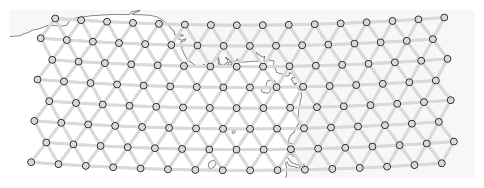

In [13]:
fig = plt.figure(dpi=100)
sp_Graph_def.fit(lamb=15.)
projection=ccrs.EquidistantConic(central_longitude=np.median(coord[:,0]), central_latitude=np.median(coord[:,1]))
ax = fig.add_subplot(1, 1, 1, projection=projection)
v = Viz(ax, sp_Graph_def, projection=projection, edge_width=2, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=False)
v.draw_obs_nodes(use_ids=False) 
# plot_estimated_vs_simulated_edges(sp_Graph_def, w_true=[1.0]*len(sp_Graph_def.edges), lamb=5.)
# v.draw_edge_colorbar()

In [10]:
sp_Graph_def_jt.fit(lamb=15., optimize_q='n-dim', lamb_q=1., alpha_q=1.)

constant-w/variance fit, converged in 128 iterations, train_loss=12406.3859830
lambda=15.0000000, alpha=0.6882422, converged in 15 iterations, train_loss=9394.2476716


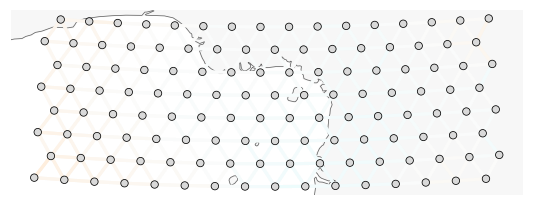

In [19]:
fig = plt.figure(dpi=110)
ax = fig.add_subplot(1, 1, 1, projection=projection)
v = Viz(ax, sp_Graph_def_jt, projection=projection, edge_width=2, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", 
        cbar_font_size=10)
v.draw_map()
v.draw_edges(use_weights=True)
v.draw_obs_nodes(use_ids=False)
# v.draw_edge_colorbar()

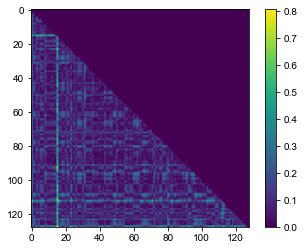

In [21]:
resnode = plot_residual_matrix(sp_Graph_def, lamb_cv=50.)
plt.imshow(resnode); plt.colorbar()

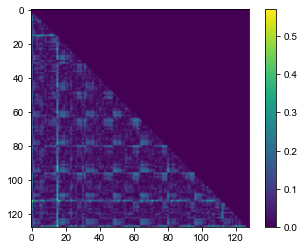

In [20]:
resnode_jt = plot_residual_matrix(sp_Graph_def_jt, lamb_cv=50.)
plt.imshow(resnode_jt); plt.colorbar()

(array([ 1.,  0.,  0.,  3., 15., 24., 33., 30., 16.,  6.]),
 array([-0.33860468, -0.28093533, -0.22326597, -0.16559662, -0.10792727,
        -0.05025792,  0.00741144,  0.06508079,  0.12275014,  0.18041949,
         0.23808885]),
 <BarContainer object of 10 artists>)

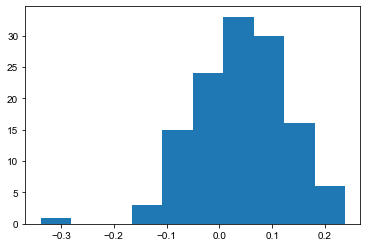

In [24]:
# obj = Objective(sp_Graph_def)
# fit_cov, _, emp_cov = comp_mats(obj)
# plt.imshow(fit_cov-emp_cov); plt.colorbar(); plt.title('fit_cov - emp_cov')
plt.hist(np.diag(fit_cov-emp_cov))

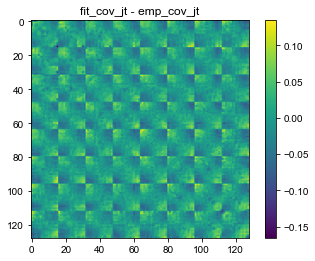

Text(0, 0.5, 'diagonal of matrix AFTER joint opt')

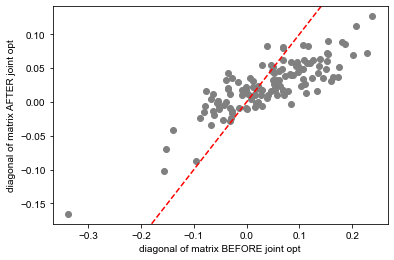

In [30]:
# obj_jt = Objective(sp_Graph_def_jt)
# fit_cov_jt, _, emp_cov_jt = comp_mats(obj_jt)
plt.imshow(fit_cov_jt-emp_cov_jt); plt.colorbar(); plt.title('fit_cov_jt - emp_cov_jt')
plt.show()
plt.scatter(np.diag(fit_cov-emp_cov),np.diag(fit_cov_jt-emp_cov_jt),color='grey')
plt.axline((0,0),slope=1,color='red',ls='--')
plt.xlabel('diagonal of matrix BEFORE joint opt'); plt.ylabel('diagonal of matrix AFTER joint opt')

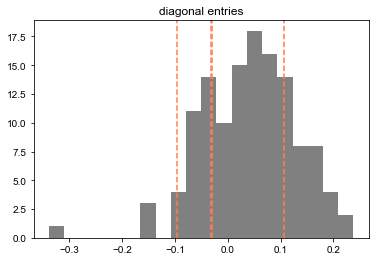

In [31]:
from operator import itemgetter
plt.hist(np.diag(fit_cov) - np.diag(emp_cov), color='grey', bins=20); plt.title('diagonal entries')
for x in list(itemgetter(*[0,7,40,47])(np.array(np.diag(fit_cov) - np.diag(emp_cov)))):
    plt.axvline(x,color='coral',ls='--')

In [64]:
[itemgetter(*[0,7,40,47])(np.array(np.diag(fit_cov) - np.diag(emp_cov)))]

[(0.11014431184139006,
  0.5426959553635726,
  0.0835822705994338,
  0.7255898453366363)]

In [32]:
max_res_nodes = comp_genetic_vs_fitted_distance(sp_Graph_def_jt, n_lre=5, lamb=5.0, plotFig=False)
max_res_nodes

[(80, 109), (49, 95), (62, 96), (62, 80), (60, 80)]

In [78]:
edges_lr = deepcopy(edge)
edges_lr = edges_lr.tolist()
for x in max_res_nodes:
    edges_lr.append(list(tuple(y+1 for y in x)))
# # resampling the genotypes matrix
sp_Graph = SpatialGraph(gen_test, coord, grid, np.array(edges_lr), long_range_edges=max_res_nodes)

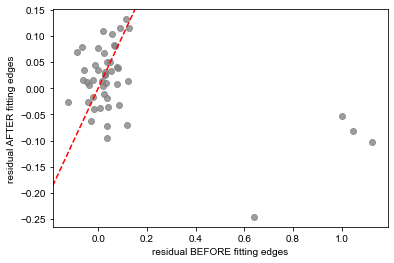

In [79]:
# plt.hist(np.diag(fit_cov_lr) - np.diag(emp_cov_lr), color='grey', bins=20)
# for x in list(itemgetter(*[0,7,40,47])(np.array(np.diag(fit_cov_lr) - np.diag(emp_cov_lr)))):
#     plt.axvline(x,color='coral',ls='--')
plt.scatter(np.diag(fit_cov) - np.diag(emp_cov), np.diag(fit_cov_lr) - np.diag(emp_cov_lr), color='grey', alpha=0.76)
plt.ylabel('residual AFTER fitting edges'); plt.xlabel('residual BEFORE fitting edges')
plt.axline((0,0),slope=1,color='red',ls='--')

In [19]:
# reverse the order of lambdas and alphas for warmstart
lamb_grid = np.geomspace(1e-2, 1e3, 20)[::-1]

# run cross-validation
cv_err = run_cv(sp_Graph, lamb_grid, n_folds=20, factr=1e10)

# # average over folds
mean_cv_err = np.mean(cv_err, axis=0)

# # argmin of cv error
lamb_cv = float(lamb_grid[np.argmin(mean_cv_err)])
lamb_cv


 fold= 0
iteration lambda=20/20 alpha=1/1
 fold= 1
iteration lambda=20/20 alpha=1/1
 fold= 2
iteration lambda=20/20 alpha=1/1
 fold= 3
iteration lambda=20/20 alpha=1/1
 fold= 4
iteration lambda=20/20 alpha=1/1
 fold= 5
iteration lambda=20/20 alpha=1/1
 fold= 6
iteration lambda=20/20 alpha=1/1
 fold= 7
iteration lambda=20/20 alpha=1/1
 fold= 8
iteration lambda=20/20 alpha=1/1
 fold= 9
iteration lambda=20/20 alpha=1/1
 fold= 10
iteration lambda=20/20 alpha=1/1
 fold= 11
iteration lambda=20/20 alpha=1/1
 fold= 12
iteration lambda=20/20 alpha=1/1
 fold= 13
iteration lambda=20/20 alpha=1/1
 fold= 14
iteration lambda=20/20 alpha=1/1
 fold= 15
iteration lambda=20/20 alpha=1/1
 fold= 16
iteration lambda=20/20 alpha=1/1
 fold= 17
iteration lambda=20/20 alpha=1/1
 fold= 18
iteration lambda=20/20 alpha=1/1
 fold= 19
iteration lambda=20/20 alpha=1/1

297.63514416313194

constant-w/variance fit, converged in 111 iterations, train_loss=6634.8438111
lambda=100.00000, alpha=0.89537, beta=0.00000, converged in 6 iterations, train_loss=7086.80456


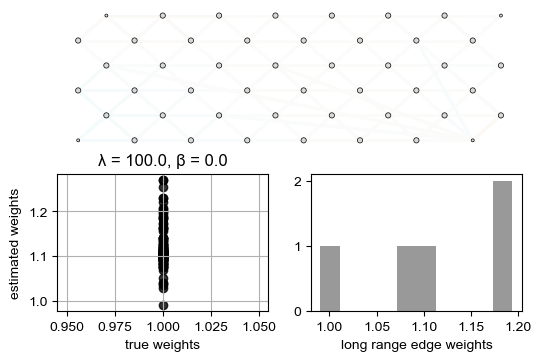

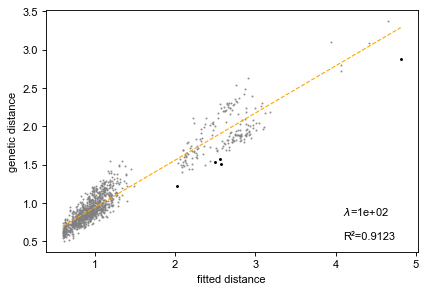

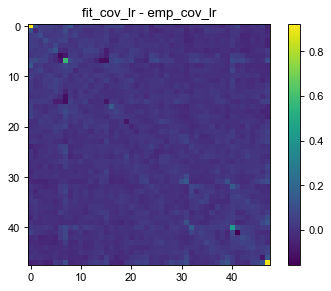

In [80]:
# fig = plt.figure(dpi=100)
# sp_Graph.fit(lamb=1.)
# # projection=ccrs.EquidistantConic(central_longitude=np.median(coord[:,0]), central_latitude=np.median(coord[:,1]))
# ax = fig.add_subplot(1, 1, 1, projection=projection)
# v = Viz(ax, sp_Graph, projection=projection, edge_width=2, 
#         edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
#         obs_node_size=7.5, sample_pt_color="black", 
#         cbar_font_size=10)
# v.draw_map()
# v.draw_edges(use_weights=True)
# v.draw_obs_nodes(use_ids=False) 
plot_estimated_vs_simulated_edges(sp_Graph, w_true=[1.0]*len(sp_Graph.edges), lrn = max_res_nodes, lamb=100.)
# v.draw_edge_colorbar()

### Step 2 - incorporating archaic admixture

In [321]:
n_rows, n_columns = 8, 16

## using 1.0 to ensure all nodes are sampled equally well 
# but need to ensure that edge pops have drifted out quite a bit (maybe set unequal numbers for each node?)
graph, coord, grid, edge = setup_graph(n_rows=n_rows, n_columns=n_columns, corridor_w=1.0, barrier_w=1.0, barrier_prob=1.0, corridor_left_prob=1., corridor_right_prob=1., barrier_startpt=0.5, barrier_endpt=6.5, n_samples_per_node=15)

gen_test = simulate_genotypes(graph, n_print=150)

Simulating ~SNP 0
Simulating ~SNP 600
Simulating ~SNP 750
Simulating ~SNP 900


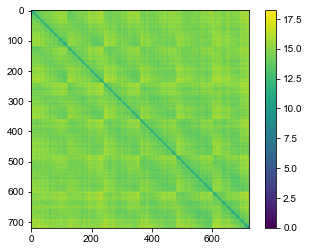

In [332]:
# import scipy.spatial
plt.imshow(scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(gen_test))); plt.colorbar()

In [333]:
np.savetxt('/Users/vivaswat/feems/feems/data/sims/infiles/arcadm.coords',coord,fmt='%f')
np.savetxt('/Users/vivaswat/feems/feems/data/sims/infiles/arcadm.outer',[[-0.1,-0.1],[n_columns+0.1,-0.1],[n_columns+0.1,n_rows+0.1],[-0.1,n_rows+0.1],[-0.1,-0.1]],fmt='%f')

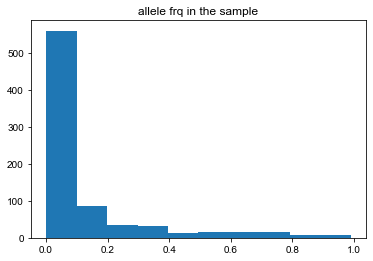

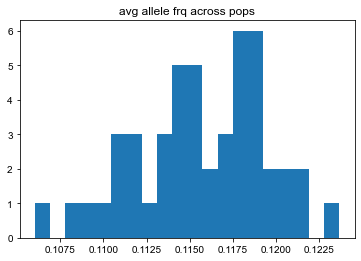

In [334]:
## setting the two pops that will be admixed
rp1, rp2 = 9, 29 

avg_af = np.sum(gen_test, axis=0)/(2.*gen_test.shape[0])
plt.hist(avg_af); plt.title('allele frq in the sample')
plt.show()

pop_af = np.asarray([np.sum(gen_test[i*15:(i+1)*15,:], axis=0)/30. for i in range(n_rows*n_columns)])
plt.hist(np.mean(pop_af, axis=1), 20); plt.title('avg allele frq across pops')
plt.show()

In [335]:
driftpar = 0.15

# getting new genotypes for these two pops
gen_test[rp1*15:(rp1+1)*15,:] = np.random.binomial(2, np.clip(np.mean(pop_af, axis=0)+driftpar,a_min=0,a_max=1), (15, gen_test.shape[1]))
gen_test[rp2*15:(rp2+1)*15,:] = np.random.binomial(2, np.clip(np.mean(pop_af, axis=0)+driftpar,a_min=0,a_max=1), (15, gen_test.shape[1]))

In [337]:
# np.savetxt('/Users/vivaswat/feems/feems/data/sims/infiles/arcadm.diffs',scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(gen_test)),fmt='%f')
gen_test.shape

(720, 789)

In [119]:
sp_Graph_def = SpatialGraph(gen_test, coord, grid, edge)

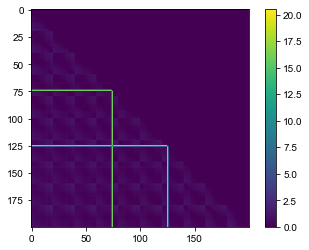

In [170]:
# resnode = plot_residual_matrix(sp_Graph_def, lamb_cv=500.)
plt.imshow(resnode); plt.colorbar()

In [149]:
obj = Objective(sp_Graph_def)
fit_cov, _, emp_cov = comp_mats(obj)
print(fit_cov[125,125], fit_cov[74,74])
print(emp_cov[125,125], emp_cov[74,74])

0.9009646258546571 0.9015220043028125
20.613455639456856 19.99868075086624


In [153]:
tril_idx = np.tril_indices(sp_Graph_def.n_observed_nodes, k=-1)
fit_dist = cov_to_dist(fit_cov)[tril_idx]
emp_dist = cov_to_dist(emp_cov)[tril_idx]

X = sm.add_constant(fit_dist)
mod = sm.OLS(emp_dist, X)
res = mod.fit()

(array([  2.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 198.]),
 array([-19.71249101, -17.68242039, -15.65234977, -13.62227914,
        -11.59220852,  -9.5621379 ,  -7.53206727,  -5.50199665,
         -3.47192602,  -1.4418554 ,   0.58821522]),
 <BarContainer object of 10 artists>)

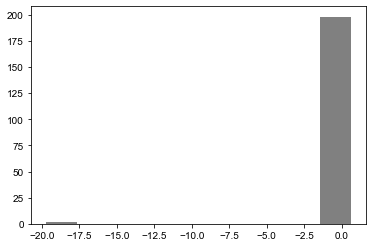

In [164]:
plt.hist(np.diag(fit_cov) - np.diag(emp_cov), color='grey', bins=10)

In [59]:
# reverse the order of lambdas and alphas for warmstart
lamb_grid = np.geomspace(1e-2, 1e3, 20)[::-1]

# run cross-validation
cv_err = run_cv(sp_Graph_def, lamb_grid, n_folds=20, factr=1e10)

# # average over folds
mean_cv_err = np.mean(cv_err, axis=0)

# # argmin of cv error
lamb_cv = float(lamb_grid[np.argmin(mean_cv_err)])
lamb_cv


 fold= 0
iteration lambda=20/20 alpha=1/1
 fold= 1
iteration lambda=20/20 alpha=1/1
 fold= 2
iteration lambda=20/20 alpha=1/1
 fold= 3
iteration lambda=20/20 alpha=1/1
 fold= 4
iteration lambda=20/20 alpha=1/1
 fold= 5
iteration lambda=20/20 alpha=1/1
 fold= 6
iteration lambda=20/20 alpha=1/1
 fold= 7
iteration lambda=20/20 alpha=1/1
 fold= 8
iteration lambda=20/20 alpha=1/1
 fold= 9
iteration lambda=20/20 alpha=1/1
 fold= 10
iteration lambda=20/20 alpha=1/1
 fold= 11
iteration lambda=20/20 alpha=1/1
 fold= 12
iteration lambda=20/20 alpha=1/1
 fold= 13
iteration lambda=20/20 alpha=1/1
 fold= 14
iteration lambda=20/20 alpha=1/1
 fold= 15
iteration lambda=20/20 alpha=1/1
 fold= 16
iteration lambda=20/20 alpha=1/1
 fold= 17
iteration lambda=20/20 alpha=1/1
 fold= 18
iteration lambda=20/20 alpha=1/1
 fold= 19
iteration lambda=20/20 alpha=1/1

545.5594781168514

constant-w/variance fit, converged in 148 iterations, train_loss=47827.1100825
lambda=500.00000, alpha=0.38641, beta=0.00000, converged in 50 iterations, train_loss=38525.68936


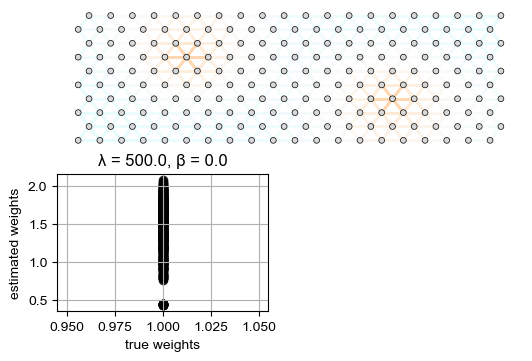

In [121]:
plot_estimated_vs_simulated_edges(sp_Graph_def, w_true=[1.0]*len(sp_Graph_def.edges), lamb=500.)

In [133]:
max_res_nodes = comp_genetic_vs_fitted_distance(sp_Graph_def, n_lre=10, lamb=20.0, plotFig=False)
max_res_nodes

[(18, 180),
 (39, 180),
 (19, 180),
 (18, 160),
 (18, 181),
 (18, 120),
 (39, 160),
 (39, 181),
 (19, 181),
 (19, 160)]

In [172]:
edges_lr = deepcopy(edge)
edges_lr = edges_lr.tolist()
for x in [(125,74)]: # max_res_nodes
    edges_lr.append(list(tuple(y+1 for y in x)))
# # resampling the genotypes matrix
sp_Graph = SpatialGraph(gen_test, coord, grid, np.array(edges_lr), long_range_edges=[(125,74)])

In [66]:
# reverse the order of lambdas and alphas for warmstart
lamb_grid = np.geomspace(1e-2, 1e3, 20)[::-1]

# run cross-validation
cv_err = run_cv(sp_Graph, lamb_grid, n_folds=20, factr=1e10)

# # average over folds
mean_cv_err = np.mean(cv_err, axis=0)

# # argmin of cv error
lamb_cv = float(lamb_grid[np.argmin(mean_cv_err)])
lamb_cv


 fold= 0
iteration lambda=20/20 alpha=1/1
 fold= 1
iteration lambda=20/20 alpha=1/1
 fold= 2
iteration lambda=20/20 alpha=1/1
 fold= 3
iteration lambda=20/20 alpha=1/1
 fold= 4
iteration lambda=20/20 alpha=1/1
 fold= 5
iteration lambda=20/20 alpha=1/1
 fold= 6
iteration lambda=20/20 alpha=1/1
 fold= 7
iteration lambda=20/20 alpha=1/1
 fold= 8
iteration lambda=20/20 alpha=1/1
 fold= 9
iteration lambda=20/20 alpha=1/1
 fold= 10
iteration lambda=20/20 alpha=1/1
 fold= 11
iteration lambda=20/20 alpha=1/1
 fold= 12
iteration lambda=20/20 alpha=1/1
 fold= 13
iteration lambda=20/20 alpha=1/1
 fold= 14
iteration lambda=20/20 alpha=1/1
 fold= 15
iteration lambda=20/20 alpha=1/1
 fold= 16
iteration lambda=20/20 alpha=1/1
 fold= 17
iteration lambda=20/20 alpha=1/1
 fold= 18
iteration lambda=20/20 alpha=1/1
 fold= 19
iteration lambda=20/20 alpha=1/1

162.3776739188721

In [174]:
sp_Graph.fit(lamb=200.)
obj_lr = Objective(sp_Graph)
fit_cov_lr, _, emp_cov_lr = comp_mats(obj_lr)
print(fit_cov_lr[125,125], fit_cov_lr[74,74])
print(emp_cov_lr[125,125], emp_cov_lr[74,74])

constant-w/variance fit, converged in 158 iterations, train_loss=48198.2374580
lambda=200.00000, alpha=0.38384, beta=0.00000, converged in 42 iterations, train_loss=19110.57370
1.3645130442312148 1.3621918083720108
20.613455639456856 19.99868075086624


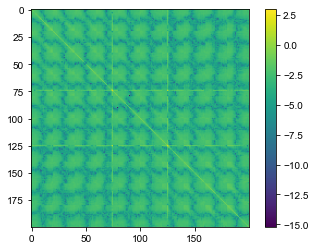

In [183]:
# resnode_lr = plot_residual_matrix(sp_Graph, 200.)
plt.imshow(fit_cov-emp_cov); plt.colorbar()

[]

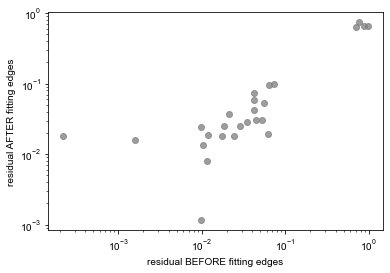

In [258]:
# plt.hist(np.diag(fit_cov_lr) - np.diag(emp_cov_lr), color='grey', bins=10)
plt.scatter(np.diag(fit_cov) - np.diag(emp_cov), np.diag(fit_cov_lr) - np.diag(emp_cov_lr), color='grey', alpha=0.76)
plt.ylabel('residual AFTER fitting edges'); plt.xlabel('residual BEFORE fitting edges')
plt.axline((0,0),slope=1,color='red',ls='--')

constant-w/variance fit, converged in 158 iterations, train_loss=48198.2374580
lambda=200.00000, alpha=0.38384, beta=0.00000, converged in 20 iterations, train_loss=30066.01143


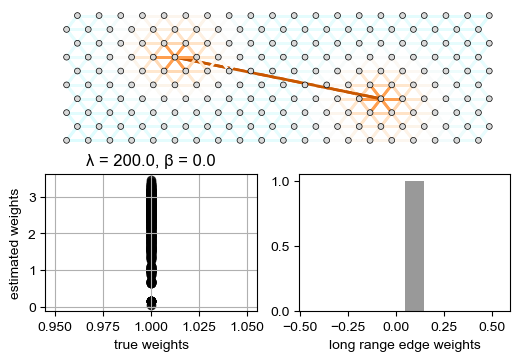

In [194]:
plot_estimated_vs_simulated_edges(sp_Graph, w_true=[1.0]*len(sp_Graph.edges), lrn=[(125,74)], lamb=200.)

In [131]:
## checking if the log-likelihood of this model is higher than if I add "correct" edges
obj = Objective(sp_Graph_def)
obj.inv()
print(obj.neg_log_lik())
obj_lr = Objective(sp_Graph)
obj_lr.inv()
print(obj_lr.neg_log_lik())
if obj_lr.neg_log_lik() < obj.neg_log_lik():
    print("Model with long-range edges fits better than default by %.2f log units with p-value of %.2e"%(-2.*(obj_lr.neg_log_lik() - obj.neg_log_lik()),chi2.sf(-2.*(obj_lr.neg_log_lik() - obj.neg_log_lik()),5)))

21855.949453274887
-44420.86806459824
Model with long-range edges fits better than default by 132553.64 log units with p-value of 0.00e+00


In [132]:
sp_Graph.edges

EdgeView([(0, 1), (0, 20), (1, 2), (1, 21), (1, 20), (2, 3), (2, 22), (2, 21), (3, 4), (3, 23), (3, 22), (4, 5), (4, 24), (4, 23), (5, 6), (5, 25), (5, 24), (6, 7), (6, 26), (6, 25), (7, 8), (7, 27), (7, 26), (8, 9), (8, 28), (8, 27), (9, 10), (9, 29), (9, 28), (10, 11), (10, 30), (10, 29), (11, 12), (11, 31), (11, 30), (12, 13), (12, 32), (12, 31), (13, 14), (13, 33), (13, 32), (14, 15), (14, 34), (14, 33), (15, 16), (15, 35), (15, 34), (16, 17), (16, 36), (16, 35), (17, 18), (17, 37), (17, 36), (18, 19), (18, 38), (18, 37), (19, 39), (19, 38), (20, 21), (20, 40), (20, 41), (21, 22), (21, 41), (21, 42), (22, 23), (22, 42), (22, 43), (23, 24), (23, 43), (23, 44), (24, 25), (24, 44), (24, 45), (25, 26), (25, 45), (25, 46), (26, 27), (26, 46), (26, 47), (27, 28), (27, 47), (27, 48), (28, 29), (28, 48), (28, 49), (29, 30), (29, 49), (29, 50), (30, 31), (30, 50), (30, 51), (31, 32), (31, 51), (31, 52), (32, 33), (32, 52), (32, 53), (33, 34), (33, 53), (33, 54), (34, 35), (34, 54), (34, 55)